In [1]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

2024-12-01 22:11:40.995290: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-01 22:11:40.999610: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-01 22:11:41.010800: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733109101.029507  451454 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733109101.035455  451454 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-01 22:11:41.054900: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
content_image_paths = ["./Images/citylandscape.jpg",
                       "./Images/queenelizabeth.jpg",
                       "./Images/roadlandscape.jpg",
                       "./Images/tiger.jpg",
                       "./Images/zebra.jpg",
                       "./Images/beachlandscape.jpg",
                       "./Images/declaration-independence.jpg", 
                       "./Images/derivative.jpg", 
                       "./Images/painted-ladies.jpg", 
                       "./Images/uva-evening.jpg"]

style_images_paths = ["./wiki_art_images/abstract_expressionism/abstract_expressionism_1.jpg",
             "./wiki_art_images/action_painting/action_painting_1.jpg",
             "./wiki_art_images/analytical_cubism/analytical_cubism_1.jpg",
             "./wiki_art_images/art_nouveau_modern/art_nouveau_modern_1.jpg",
             "./wiki_art_images/baroque/baroque_1.jpg",
             "./wiki_art_images/color_field_painting/color_field_painting_1.jpg",
             "./wiki_art_images/contemporary_realism/contemporary_realism_1.jpg",
             "./wiki_art_images/cubism/cubism_1.jpg",
             "./wiki_art_images/early_renaissance/early_renaissance_1.jpg",
             "./wiki_art_images/expressionism/expressionism_1.jpg",
             "./wiki_art_images/fauvism/fauvism_1.jpg",
             "./wiki_art_images/high_renaissance/high_renaissance_1.jpg",
             "./wiki_art_images/impressionism/impressionism_1.jpg",
             "./wiki_art_images/mannerism_late_renaissance/mannerism_late_renaissance_1.jpg",
             "./wiki_art_images/minimalism/minimalism_1.jpg",
             "./wiki_art_images/naive_art_primitivism/naive_art_primitivism_1.jpg",
             "./wiki_art_images/new_realism/new_realism_1.jpg",
             "./wiki_art_images/northern_renaissance/northern_renaissance_1.jpg",
             "./wiki_art_images/pointillism/pointillism_1.jpg",
             "./wiki_art_images/pop_art/pop_art_1.jpg",
             "./wiki_art_images/post_impressionism/post_impressionism_1.jpg",
             "./wiki_art_images/realism/realism_1.jpg",
             "./wiki_art_images/rococo/rococo_1.jpg",
             "./wiki_art_images/romanticism/romanticism_1.jpg",
             "./wiki_art_images/symbolism/symbolism_1.jpg",
             "./wiki_art_images/synthetic_cubism/synthetic_cubism_1.jpg",
             "./wiki_art_images/ukiyo_e/ukiyo_e_1.jpg"]

In [3]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

In [4]:
def vgg_layers(layer_names):
    """ Creates a VGG model that returns a list of intermediate output values."""
    # Load our model. Load pretrained VGG, trained on ImageNet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
  
    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name: value
                        for content_name, value
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name: value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}
    
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def style_content_loss(outputs, style_targets, content_targets):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([
        tf.reduce_mean((style_outputs[name] - style_targets[name])**2)
        for name in style_outputs.keys()
    ])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([
        tf.reduce_mean((content_outputs[name] - content_targets[name])**2)
        for name in content_outputs.keys()
    ])
    content_loss *= content_weight / num_content_layers
    return style_loss + content_loss


@tf.function
def train_step(image, style_targets, content_targets):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs, style_targets, content_targets)
        loss += total_variation_weight * tf.image.total_variation(image)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

In [19]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

style_weight=1e-2
content_weight=1e4
total_variation_weight=30
epochs = 10
steps_per_epoch = 100

output_base_folder = "./style_images"

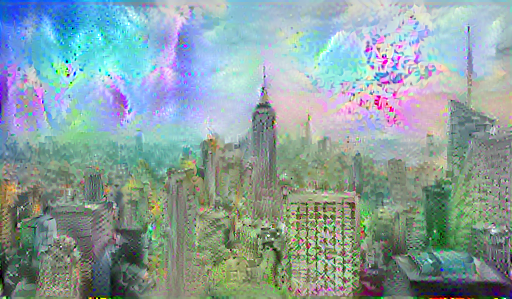

Train step: 1000


In [20]:
style_path = style_images_paths[0]
style_image = load_img(style_path)

style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

extractor = StyleContentModel(style_layers, content_layers)
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_targets = extractor(style_image)['style']

content_path = content_image_paths[0]
content_name = os.path.splitext(os.path.basename(content_path))[0]
content_output_folder = os.path.join(output_base_folder, content_name)
os.makedirs(content_output_folder, exist_ok=True)
style_type = os.path.basename(os.path.dirname(style_path))
# Create output folder for the style type under this content image
style_type_folder = os.path.join(content_output_folder, style_type)
os.makedirs(style_type_folder, exist_ok=True)

content_image = load_img(content_path)
content_targets = extractor(content_image)['content']
results = extractor(tf.constant(content_image))

image = tf.Variable(content_image)
    
step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image, style_targets, content_targets)
        print(".", end='', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

output_image = tensor_to_image(image)
output_image.save(os.path.join(style_type_folder, f"{content_name}_{style_type}.jpg"))

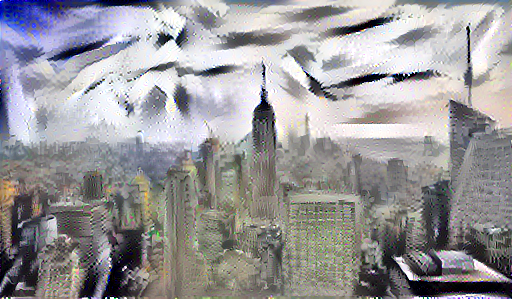

Train step: 800
...................................................................

In [ ]:
style_path = style_images_paths[1]
style_image = load_img(style_path)

style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

extractor = StyleContentModel(style_layers, content_layers)
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_targets = extractor(style_image)['style']

style_type = os.path.basename(os.path.dirname(style_path))
# Create output folder for the style type under this content image
style_type_folder = os.path.join(content_output_folder, style_type)
os.makedirs(style_type_folder, exist_ok=True)

# content_image = load_img(content_path)
content_targets = extractor(content_image)['content']
results = extractor(tf.constant(content_image))

image = tf.Variable(content_image)
    
step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image, style_targets, content_targets)
        print(".", end='', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

output_image = tensor_to_image(image)
output_image.save(os.path.join(style_type_folder, f"{content_name}_{style_type}.jpg"))

In [ ]:
style_path = style_images_paths[2]
style_image = load_img(style_path)

style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

extractor = StyleContentModel(style_layers, content_layers)
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_targets = extractor(style_image)['style']

style_type = os.path.basename(os.path.dirname(style_path))
# Create output folder for the style type under this content image
style_type_folder = os.path.join(content_output_folder, style_type)
os.makedirs(style_type_folder, exist_ok=True)

# content_image = load_img(content_path)
content_targets = extractor(content_image)['content']
results = extractor(tf.constant(content_image))

image = tf.Variable(content_image)
    
step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image, style_targets, content_targets)
        print(".", end='', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

output_image = tensor_to_image(image)
output_image.save(os.path.join(style_type_folder, f"{content_name}_{style_type}.jpg"))

In [ ]:
style_path = style_images_paths[3]
style_image = load_img(style_path)

style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

extractor = StyleContentModel(style_layers, content_layers)
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_targets = extractor(style_image)['style']

style_type = os.path.basename(os.path.dirname(style_path))
# Create output folder for the style type under this content image
style_type_folder = os.path.join(content_output_folder, style_type)
os.makedirs(style_type_folder, exist_ok=True)

# content_image = load_img(content_path)
content_targets = extractor(content_image)['content']
results = extractor(tf.constant(content_image))

image = tf.Variable(content_image)
    
step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image, style_targets, content_targets)
        print(".", end='', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

output_image = tensor_to_image(image)
output_image.save(os.path.join(style_type_folder, f"{content_name}_{style_type}.jpg"))

In [ ]:
style_path = style_images_paths[4]
style_image = load_img(style_path)

style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

extractor = StyleContentModel(style_layers, content_layers)
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_targets = extractor(style_image)['style']

style_type = os.path.basename(os.path.dirname(style_path))
# Create output folder for the style type under this content image
style_type_folder = os.path.join(content_output_folder, style_type)
os.makedirs(style_type_folder, exist_ok=True)

# content_image = load_img(content_path)
content_targets = extractor(content_image)['content']
results = extractor(tf.constant(content_image))

image = tf.Variable(content_image)
    
step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image, style_targets, content_targets)
        print(".", end='', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

output_image = tensor_to_image(image)
output_image.save(os.path.join(style_type_folder, f"{content_name}_{style_type}.jpg"))

In [ ]:
style_path = style_images_paths[5]
style_image = load_img(style_path)

style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

extractor = StyleContentModel(style_layers, content_layers)
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_targets = extractor(style_image)['style']

style_type = os.path.basename(os.path.dirname(style_path))
# Create output folder for the style type under this content image
style_type_folder = os.path.join(content_output_folder, style_type)
os.makedirs(style_type_folder, exist_ok=True)

# content_image = load_img(content_path)
content_targets = extractor(content_image)['content']
results = extractor(tf.constant(content_image))

image = tf.Variable(content_image)
    
step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image, style_targets, content_targets)
        print(".", end='', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

output_image = tensor_to_image(image)
output_image.save(os.path.join(style_type_folder, f"{content_name}_{style_type}.jpg"))

In [ ]:
style_path = style_images_paths[6]
style_image = load_img(style_path)

style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

extractor = StyleContentModel(style_layers, content_layers)
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_targets = extractor(style_image)['style']

style_type = os.path.basename(os.path.dirname(style_path))
# Create output folder for the style type under this content image
style_type_folder = os.path.join(content_output_folder, style_type)
os.makedirs(style_type_folder, exist_ok=True)

# content_image = load_img(content_path)
content_targets = extractor(content_image)['content']
results = extractor(tf.constant(content_image))

image = tf.Variable(content_image)
    
step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image, style_targets, content_targets)
        print(".", end='', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

output_image = tensor_to_image(image)
output_image.save(os.path.join(style_type_folder, f"{content_name}_{style_type}.jpg"))

In [ ]:
style_path = style_images_paths[7]
style_image = load_img(style_path)

style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

extractor = StyleContentModel(style_layers, content_layers)
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_targets = extractor(style_image)['style']

style_type = os.path.basename(os.path.dirname(style_path))
# Create output folder for the style type under this content image
style_type_folder = os.path.join(content_output_folder, style_type)
os.makedirs(style_type_folder, exist_ok=True)

# content_image = load_img(content_path)
content_targets = extractor(content_image)['content']
results = extractor(tf.constant(content_image))

image = tf.Variable(content_image)
    
step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image, style_targets, content_targets)
        print(".", end='', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

output_image = tensor_to_image(image)
output_image.save(os.path.join(style_type_folder, f"{content_name}_{style_type}.jpg"))

In [ ]:
style_path = style_images_paths[8]
style_image = load_img(style_path)

style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

extractor = StyleContentModel(style_layers, content_layers)
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_targets = extractor(style_image)['style']

style_type = os.path.basename(os.path.dirname(style_path))
# Create output folder for the style type under this content image
style_type_folder = os.path.join(content_output_folder, style_type)
os.makedirs(style_type_folder, exist_ok=True)

# content_image = load_img(content_path)
content_targets = extractor(content_image)['content']
results = extractor(tf.constant(content_image))

image = tf.Variable(content_image)
    
step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image, style_targets, content_targets)
        print(".", end='', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

output_image = tensor_to_image(image)
output_image.save(os.path.join(style_type_folder, f"{content_name}_{style_type}.jpg"))

In [ ]:
style_path = style_images_paths[9]
style_image = load_img(style_path)

style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

extractor = StyleContentModel(style_layers, content_layers)
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_targets = extractor(style_image)['style']

style_type = os.path.basename(os.path.dirname(style_path))
# Create output folder for the style type under this content image
style_type_folder = os.path.join(content_output_folder, style_type)
os.makedirs(style_type_folder, exist_ok=True)

# content_image = load_img(content_path)
content_targets = extractor(content_image)['content']
results = extractor(tf.constant(content_image))

image = tf.Variable(content_image)
    
step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image, style_targets, content_targets)
        print(".", end='', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

output_image = tensor_to_image(image)
output_image.save(os.path.join(style_type_folder, f"{content_name}_{style_type}.jpg"))

In [ ]:
style_path = style_images_paths[10]
style_image = load_img(style_path)

style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

extractor = StyleContentModel(style_layers, content_layers)
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_targets = extractor(style_image)['style']

style_type = os.path.basename(os.path.dirname(style_path))
# Create output folder for the style type under this content image
style_type_folder = os.path.join(content_output_folder, style_type)
os.makedirs(style_type_folder, exist_ok=True)

# content_image = load_img(content_path)
content_targets = extractor(content_image)['content']
results = extractor(tf.constant(content_image))

image = tf.Variable(content_image)
    
step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image, style_targets, content_targets)
        print(".", end='', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

output_image = tensor_to_image(image)
output_image.save(os.path.join(style_type_folder, f"{content_name}_{style_type}.jpg"))

In [ ]:
style_path = style_images_paths[11]
style_image = load_img(style_path)

style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

extractor = StyleContentModel(style_layers, content_layers)
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_targets = extractor(style_image)['style']

style_type = os.path.basename(os.path.dirname(style_path))
# Create output folder for the style type under this content image
style_type_folder = os.path.join(content_output_folder, style_type)
os.makedirs(style_type_folder, exist_ok=True)

# content_image = load_img(content_path)
content_targets = extractor(content_image)['content']
results = extractor(tf.constant(content_image))

image = tf.Variable(content_image)
    
step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image, style_targets, content_targets)
        print(".", end='', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

output_image = tensor_to_image(image)
output_image.save(os.path.join(style_type_folder, f"{content_name}_{style_type}.jpg"))

In [ ]:
style_path = style_images_paths[12]
style_image = load_img(style_path)

style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

extractor = StyleContentModel(style_layers, content_layers)
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_targets = extractor(style_image)['style']

style_type = os.path.basename(os.path.dirname(style_path))
# Create output folder for the style type under this content image
style_type_folder = os.path.join(content_output_folder, style_type)
os.makedirs(style_type_folder, exist_ok=True)

# content_image = load_img(content_path)
content_targets = extractor(content_image)['content']
results = extractor(tf.constant(content_image))

image = tf.Variable(content_image)
    
step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image, style_targets, content_targets)
        print(".", end='', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

output_image = tensor_to_image(image)
output_image.save(os.path.join(style_type_folder, f"{content_name}_{style_type}.jpg"))

In [ ]:
style_path = style_images_paths[13]
style_image = load_img(style_path)

style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

extractor = StyleContentModel(style_layers, content_layers)
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_targets = extractor(style_image)['style']

style_type = os.path.basename(os.path.dirname(style_path))
# Create output folder for the style type under this content image
style_type_folder = os.path.join(content_output_folder, style_type)
os.makedirs(style_type_folder, exist_ok=True)

# content_image = load_img(content_path)
content_targets = extractor(content_image)['content']
results = extractor(tf.constant(content_image))

image = tf.Variable(content_image)
    
step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image, style_targets, content_targets)
        print(".", end='', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

output_image = tensor_to_image(image)
output_image.save(os.path.join(style_type_folder, f"{content_name}_{style_type}.jpg"))

In [ ]:
style_path = style_images_paths[14]
style_image = load_img(style_path)

style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

extractor = StyleContentModel(style_layers, content_layers)
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_targets = extractor(style_image)['style']

style_type = os.path.basename(os.path.dirname(style_path))
# Create output folder for the style type under this content image
style_type_folder = os.path.join(content_output_folder, style_type)
os.makedirs(style_type_folder, exist_ok=True)

# content_image = load_img(content_path)
content_targets = extractor(content_image)['content']
results = extractor(tf.constant(content_image))

image = tf.Variable(content_image)
    
step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image, style_targets, content_targets)
        print(".", end='', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

output_image = tensor_to_image(image)
output_image.save(os.path.join(style_type_folder, f"{content_name}_{style_type}.jpg"))

In [ ]:
style_path = style_images_paths[15]
style_image = load_img(style_path)

style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

extractor = StyleContentModel(style_layers, content_layers)
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_targets = extractor(style_image)['style']

style_type = os.path.basename(os.path.dirname(style_path))
# Create output folder for the style type under this content image
style_type_folder = os.path.join(content_output_folder, style_type)
os.makedirs(style_type_folder, exist_ok=True)

# content_image = load_img(content_path)
content_targets = extractor(content_image)['content']
results = extractor(tf.constant(content_image))

image = tf.Variable(content_image)
    
step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image, style_targets, content_targets)
        print(".", end='', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

output_image = tensor_to_image(image)
output_image.save(os.path.join(style_type_folder, f"{content_name}_{style_type}.jpg"))

In [ ]:
style_path = style_images_paths[16]
style_image = load_img(style_path)

style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

extractor = StyleContentModel(style_layers, content_layers)
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_targets = extractor(style_image)['style']

style_type = os.path.basename(os.path.dirname(style_path))
# Create output folder for the style type under this content image
style_type_folder = os.path.join(content_output_folder, style_type)
os.makedirs(style_type_folder, exist_ok=True)

# content_image = load_img(content_path)
content_targets = extractor(content_image)['content']
results = extractor(tf.constant(content_image))

image = tf.Variable(content_image)
    
step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image, style_targets, content_targets)
        print(".", end='', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

output_image = tensor_to_image(image)
output_image.save(os.path.join(style_type_folder, f"{content_name}_{style_type}.jpg"))

In [ ]:
style_path = style_images_paths[17]
style_image = load_img(style_path)

style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

extractor = StyleContentModel(style_layers, content_layers)
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_targets = extractor(style_image)['style']

style_type = os.path.basename(os.path.dirname(style_path))
# Create output folder for the style type under this content image
style_type_folder = os.path.join(content_output_folder, style_type)
os.makedirs(style_type_folder, exist_ok=True)

# content_image = load_img(content_path)
content_targets = extractor(content_image)['content']
results = extractor(tf.constant(content_image))

image = tf.Variable(content_image)
    
step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image, style_targets, content_targets)
        print(".", end='', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

output_image = tensor_to_image(image)
output_image.save(os.path.join(style_type_folder, f"{content_name}_{style_type}.jpg"))

In [ ]:
style_path = style_images_paths[18]
style_image = load_img(style_path)

style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

extractor = StyleContentModel(style_layers, content_layers)
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_targets = extractor(style_image)['style']

style_type = os.path.basename(os.path.dirname(style_path))
# Create output folder for the style type under this content image
style_type_folder = os.path.join(content_output_folder, style_type)
os.makedirs(style_type_folder, exist_ok=True)

# content_image = load_img(content_path)
content_targets = extractor(content_image)['content']
results = extractor(tf.constant(content_image))

image = tf.Variable(content_image)
    
step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image, style_targets, content_targets)
        print(".", end='', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

output_image = tensor_to_image(image)
output_image.save(os.path.join(style_type_folder, f"{content_name}_{style_type}.jpg"))

In [ ]:
style_path = style_images_paths[19]
style_image = load_img(style_path)

style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

extractor = StyleContentModel(style_layers, content_layers)
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_targets = extractor(style_image)['style']

style_type = os.path.basename(os.path.dirname(style_path))
# Create output folder for the style type under this content image
style_type_folder = os.path.join(content_output_folder, style_type)
os.makedirs(style_type_folder, exist_ok=True)

# content_image = load_img(content_path)
content_targets = extractor(content_image)['content']
results = extractor(tf.constant(content_image))

image = tf.Variable(content_image)
    
step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image, style_targets, content_targets)
        print(".", end='', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

output_image = tensor_to_image(image)
output_image.save(os.path.join(style_type_folder, f"{content_name}_{style_type}.jpg"))

In [ ]:
style_path = style_images_paths[20]
style_image = load_img(style_path)

style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

extractor = StyleContentModel(style_layers, content_layers)
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_targets = extractor(style_image)['style']

style_type = os.path.basename(os.path.dirname(style_path))
# Create output folder for the style type under this content image
style_type_folder = os.path.join(content_output_folder, style_type)
os.makedirs(style_type_folder, exist_ok=True)

# content_image = load_img(content_path)
content_targets = extractor(content_image)['content']
results = extractor(tf.constant(content_image))

image = tf.Variable(content_image)
    
step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image, style_targets, content_targets)
        print(".", end='', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

output_image = tensor_to_image(image)
output_image.save(os.path.join(style_type_folder, f"{content_name}_{style_type}.jpg"))

In [ ]:
style_path = style_images_paths[21]
style_image = load_img(style_path)

style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

extractor = StyleContentModel(style_layers, content_layers)
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_targets = extractor(style_image)['style']

style_type = os.path.basename(os.path.dirname(style_path))
# Create output folder for the style type under this content image
style_type_folder = os.path.join(content_output_folder, style_type)
os.makedirs(style_type_folder, exist_ok=True)

# content_image = load_img(content_path)
content_targets = extractor(content_image)['content']
results = extractor(tf.constant(content_image))

image = tf.Variable(content_image)
    
step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image, style_targets, content_targets)
        print(".", end='', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

output_image = tensor_to_image(image)
output_image.save(os.path.join(style_type_folder, f"{content_name}_{style_type}.jpg"))

In [ ]:
style_path = style_images_paths[22]
style_image = load_img(style_path)

style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

extractor = StyleContentModel(style_layers, content_layers)
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_targets = extractor(style_image)['style']

style_type = os.path.basename(os.path.dirname(style_path))
# Create output folder for the style type under this content image
style_type_folder = os.path.join(content_output_folder, style_type)
os.makedirs(style_type_folder, exist_ok=True)

# content_image = load_img(content_path)
content_targets = extractor(content_image)['content']
results = extractor(tf.constant(content_image))

image = tf.Variable(content_image)
    
step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image, style_targets, content_targets)
        print(".", end='', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

output_image = tensor_to_image(image)
output_image.save(os.path.join(style_type_folder, f"{content_name}_{style_type}.jpg"))

In [ ]:
style_path = style_images_paths[23]
style_image = load_img(style_path)

style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

extractor = StyleContentModel(style_layers, content_layers)
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_targets = extractor(style_image)['style']

style_type = os.path.basename(os.path.dirname(style_path))
# Create output folder for the style type under this content image
style_type_folder = os.path.join(content_output_folder, style_type)
os.makedirs(style_type_folder, exist_ok=True)

# content_image = load_img(content_path)
content_targets = extractor(content_image)['content']
results = extractor(tf.constant(content_image))

image = tf.Variable(content_image)
    
step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image, style_targets, content_targets)
        print(".", end='', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

output_image = tensor_to_image(image)
output_image.save(os.path.join(style_type_folder, f"{content_name}_{style_type}.jpg"))

In [ ]:
style_path = style_images_paths[24]
style_image = load_img(style_path)

style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

extractor = StyleContentModel(style_layers, content_layers)
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_targets = extractor(style_image)['style']

style_type = os.path.basename(os.path.dirname(style_path))
# Create output folder for the style type under this content image
style_type_folder = os.path.join(content_output_folder, style_type)
os.makedirs(style_type_folder, exist_ok=True)

# content_image = load_img(content_path)
content_targets = extractor(content_image)['content']
results = extractor(tf.constant(content_image))

image = tf.Variable(content_image)
    
step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image, style_targets, content_targets)
        print(".", end='', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

output_image = tensor_to_image(image)
output_image.save(os.path.join(style_type_folder, f"{content_name}_{style_type}.jpg"))

In [ ]:
style_path = style_images_paths[25]
style_image = load_img(style_path)

style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

extractor = StyleContentModel(style_layers, content_layers)
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_targets = extractor(style_image)['style']

style_type = os.path.basename(os.path.dirname(style_path))
# Create output folder for the style type under this content image
style_type_folder = os.path.join(content_output_folder, style_type)
os.makedirs(style_type_folder, exist_ok=True)

# content_image = load_img(content_path)
content_targets = extractor(content_image)['content']
results = extractor(tf.constant(content_image))

image = tf.Variable(content_image)
    
step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image, style_targets, content_targets)
        print(".", end='', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

output_image = tensor_to_image(image)
output_image.save(os.path.join(style_type_folder, f"{content_name}_{style_type}.jpg"))